# Control analysis: effect of perinatal brain injury
Adapted from `1_spatialHeterogeneity.ipynb`

Preterm birth often leads to perinatal brain injury, such as intracranial hemorrhage or focal WM lesions. As the presence or absence of such lesions might have an impact on brain morphometry and cognitive outcomes, we have performed a control analysis, which excluded subjects with perinatal brain injury from the analysis. This notebook contains the code to reproduce the results of this control analysis. Details on the assessment of perinatal brain injury can be found in the Supplement.

In [1]:
# manually set path to R if there are problems with the automatic detection
# import os
# os.environ['R_HOME'] = '/Library/Frameworks/R.framework/R'  # adapt to your R installation

In [2]:
%load_ext autoreload
%autoreload 2
# Use rpy2 to run R in python notebook for braincharts
%load_ext rpy2.ipython

In [3]:
import os
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.multitest import multipletests

import gc  # for clearing unnecessary variables

sns.set(style='white')

# import custom functions
import sys
sys.path.append('code')
from utils import get_roi_names
from plotting import get_significant_cortical_vals_for_plotting, plot_brain_map, plot_group_difference_global, plot_individual_brain_maps
from spatial_heterogeneity import *
from stats import median_difference_centiles, plot_permuation_test


# some settings - please adapt to your needs
brain_measure = 'SA'  # CT or SA
dataset = 'dHCP'  # dHCP or BLS-26
scale = 10  # scale for brain plots; run with scale = 10 for higher resolution
refit_models = True  # whether to repeat adaptation of the pretrained models to the new data, computationally intense
cpu_num = 6  # number of cores to use for refitting BrainChart models

In [4]:
# directories
data_dir = 'data'
outputs_dir = join('outputs', 'supplement', 'brain_injury')
os.makedirs(outputs_dir, exist_ok=True)

braincharts_sw_dir = 'Lifespan'

out_dir_main = join(outputs_dir, 'spatial_heterogeneity', dataset)
os.makedirs(out_dir_main, exist_ok=True)

# Load data

In [5]:
# get ROI names
rois = get_roi_names(brain_measure, global_vars=True)
rois.append('meanCT2')
rois_cortical = get_roi_names(brain_measure, global_vars=False)

# load preprocessed data
if dataset.startswith('BLS') or dataset.startswith('ABCD'):
    dataset_name = dataset[:-3]
else:
    dataset_name = dataset
data = pd.read_csv(join(data_dir, dataset_name, 'derivatives', f'{dataset}_{brain_measure}_preprocessed.csv'))

## Brain injury
Brain injury after birth was available for dHCP and BLS datasets, but not for ABCD.

In the dHCP dataset, brain injury was assessed at term equivalent age (TEA) and coded as follows in the variable `radiology_score`:
- 1: Normal appearance for age
- 2: Incidental findings with unlikely significance for clinical outcome or analysis (e.g. subdural haemorrhage. Isolated subependymal cysts. Mild Inferior vermis rotation)
- 3: Incidental findings with unlikely clinical significance but possible analysis significance (e.g. Several punctate lesions or other focal white matter/ cortical lesions not thought to be of clinical significance)
- 4: Incidental findings with possible clinical significance. Unlikely analysis significance (e.g. Isolated non brain anomaly e.g. in pituitary / on tongue)
- 5:  Incidental findings with possible/likely significance for both clinical and imaging analysis (e.g. Major lesions within white matter)
We have excluded all subjects with a score of 3 or higher, as these subjects were not considered to have brain injury.

In [6]:
# filter for subjects without brain injury
if dataset == 'dHCP':
    print(f'Number of subjects with brain injury: {len(data[data["radiology_score"] >= 3])}')
    data = data[data['radiology_score'] < 3]
    print(f'Number of subjects without brain injury: {len(data)}')
    preterm_data = data[data['dx'] == 'preterm']
    fullterm_data = data[data['dx'] == 'CN']
    print(f'New cohort size: {len(preterm_data)} preterm, {len(fullterm_data)} full-term')
    
elif dataset == 'BLS-26':
    # convert nan values in hemo to 0
    data['hemo'] = data['hemo'].fillna(0)
    print(f'Number of subjects with brain injury: {len(data[data["hemo"] > 0])}')
    data = data[data['hemo'] == 0]
    print(f'Number of subjects without intracranial hemorrhage: {len(data)}')
    preterm_data = data[data['dx'] == 'preterm']
    fullterm_data = data[data['dx'] == 'CN']
    print(f'New cohort size: {len(preterm_data)} preterm, {len(fullterm_data)} full-term')
    
subject_list = data['participant'].unique()

Number of subjects with brain injury: 140
Number of subjects without brain injury: 553
New cohort size: 67 preterm, 486 full-term


# 1. Average dysmaturation outcome after preterm birth

In [7]:
out_dir = join(out_dir_main, 'average_dysmaturation')
os.makedirs(out_dir, exist_ok=True)

if dataset == 'dHCP':
    # filter for term-equivalent age
    data = data[data['scan'] == 'term_equivalent']
    data_fetal = data[data['scan'] == 'fetal']
    print(f'Using {data.shape[0]} term-equivalent scans from dHCP dataset')

Using 553 term-equivalent scans from dHCP dataset


## Brain measure

In [8]:
# calculate group difference using OLS regression
tvals_mr = group_comparison(rois_cortical, data, covariates=['age_days', 'sex'])
tvals_mr.to_csv(join(out_dir, f'{dataset}_{brain_measure}_average_dysmaturation.csv'), index=False)

# show table and round every value to 3 decimal places, replace 0.000 with <0.001
tvals_mr_table = tvals_mr.set_index('ROI').round(3).replace(0.000, '<0.001')
tvals_mr_table.to_csv(join(out_dir, f'{dataset}_{brain_measure}_average_dysmaturation_table.csv'), index=True)
display(tvals_mr_table)

,t_statistic,Cohen_d,p_value,p_fdr
ROI,,,,
SA_bankssts,-1.882,0.326,0.06,0.228
SA_caudalanteriorcingulate,1.391,0.037,0.165,0.350
SA_caudalmiddlefrontal,-0.224,0.169,0.823,0.903
SA_cuneus,0.896,0.035,0.37,0.573
SA_entorhinal,0.855,-0.003,0.393,0.581
SA_fusiform,-1.433,0.275,0.152,0.346
SA_inferiorparietal,-1.802,0.306,0.072,0.245
SA_inferiortemporal,-0.442,0.191,0.659,0.772
SA_isthmuscingulate,-1.688,0.290,0.092,0.284


In [9]:
# plot the t-statistic only for significant ROIs after FDR-correction
sig_t = get_significant_cortical_vals_for_plotting(data=tvals_mr, rois_cortical=rois_cortical, statistic='t_statistic', bilateral=True)

outname = join(out_dir, f'{dataset}_{brain_measure}_avg_dysmaturation_term-preterm.svg')
plot_brain_map(sig_t, outname, scale=scale, limits=(-5, 5))  # larger scale improves image quality


Plotted brain map and saved it to outputs/supplement/brain_injury/spatial_heterogeneity/dHCP/average_dysmaturation/dHCP_SA_avg_dysmaturation_term-preterm.svg


## Cerebral tissue volume

In [10]:
# Average dysmaturation global
if brain_measure == 'CT':  # run only once
    rois_global = ['WMV', 'GMV', 'sGMV']
    
    tvals_mr = group_comparison(rois_global, data, covariates=['age_days', 'sex'])
    tvals_mr.to_csv(join(out_dir, f'{dataset}_global_average_dysmaturation.csv'), index=False)

    # show table and round every value to 3 decimal places, replace 0.000 with <0.001
    tvals_mr_table = tvals_mr.set_index('ROI').round(3).replace(0.000, '<0.001')
    tvals_mr_table.to_csv(join(out_dir, f'{dataset}_global_average_dysmaturation_table.csv'), index=True)
    display(tvals_mr_table)
    
    
    # plot measures of cerebral tissue volume
    for ctv_measure in rois_global:
        outname = join(out_dir, f'{dataset}_{ctv_measure}_avg_dysmaturation_term-preterm.svg')
        # in dHCP,x one outlier with sGMV = 0 was removed
        data = data[data['sGMV'] > 0]
        # plot the residuals of the group comparison
        plot_group_difference_global(data=data, x='dx', y=ctv_measure, yaxis_label = f'{ctv_measure} residuals [mm$^3$]', outname=outname)

# 2. Individual brain aberration patterns (IBAP) for each subject

In [11]:
out_dir = join(out_dir_main, f'braincharts_model_adapted_{brain_measure}')
os.makedirs(out_dir, exist_ok=True)

out_dir_analysis = join(out_dir_main, f'IBAP_{brain_measure}')
os.makedirs(out_dir_analysis, exist_ok=True)

## Refit the pretrained model and calculate deviation scores
The calculation will be done in R. Since the calculation will take some time, it is recommended to adjust the number of cores in `cpu_num` for higher processing speed. However, stick to the limits of your system!

In [12]:
%%R -i data -i rois_cortical -i out_dir -i braincharts_sw_dir -i cpu_num -i refit_models

# load required functions
source(file.path(braincharts_sw_dir, '920.calc-novel-wo-subset-function.r'))
source('code/braincharts_helpers.R')

if (refit_models == TRUE) {
    # only if refitting is necessary
    
    for (roi in rois_cortical) { 
        # adapt the pretrained model for each ROI for the current dataset and calculate deviation scores for each subject in dataset
        if (roi == 'SA_entorhinal') {
            # skip SA entorhinal as BrainChart estimation failed due to low data consistency
            next
        }
        print(roi)
        result <- fit_braincharts_model(roi, data, braincharts_sw_dir, out_dir, plotting=FALSE, ncores=cpu_num)
    } 

} else {
    # Check if the directory exists
    if (!file.exists(out_dir)) {
        warning('Models not yet adapted, please set refit_models to TRUE.')
    } else {
        message('Models already adapted, skipping refitting.')
    }
}

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::collapse() masks nlme::collapse()
✖ dplyr::filter()   masks stats::filter()
✖ dplyr::lag()      masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
[1] "SA_bankssts"
[1] "MODELLING:  SA_bankssts ...................."
[1] "Lifespan/Share/RefittedModels"
NewData inspected and any novel studies identified. Finding Maximum Likelihood estimates for random-effects. 
Computing novel random-effects for bootstrap replicates using 6 cores. This may take some time.
Novel bootstrap estimaton complete.
Novel study random-effects calculated.
Computing bootstrap intervals using 6 cores. This may take some ti

IOStream.flush timed out


Novel bootstrap estimaton complete.
Novel study random-effects calculated.
Computing bootstrap intervals using 6 cores. This may take some time.
Bootstrap intervals complete
[1] "SA_posteriorcingulate"
[1] "MODELLING:  SA_posteriorcingulate ...................."
[1] "Lifespan/Share/RefittedModels"
NewData inspected and any novel studies identified. Finding Maximum Likelihood estimates for random-effects. 
Computing novel random-effects for bootstrap replicates using 6 cores. This may take some time.
Novel bootstrap estimaton complete.
Novel study random-effects calculated.
Computing bootstrap intervals using 6 cores. This may take some time.
Bootstrap intervals complete
[1] "SA_precentral"
[1] "MODELLING:  SA_precentral ...................."
[1] "Lifespan/Share/RefittedModels"
NewData inspected and any novel studies identified. Finding Maximum Likelihood estimates for random-effects. 
Computing novel random-effects for bootstrap replicates using 6 cores. This may take some time.
Novel 

Lade nötiges Paket: splines
Lade nötiges Paket: gamlss.data

Attache Paket: ‘gamlss.data’

Das folgende Objekt ist maskiert ‘package:datasets’:

    sleep

Lade nötiges Paket: gamlss.dist
Lade nötiges Paket: nlme
 **********   GAMLSS Version 5.4-22  ********** 
For more on GAMLSS look at https://www.gamlss.com/
Type gamlssNews() to see new features/changes/bug fixes.

Zusätzlich: Es gab 23 Warnungen (Anzeige mit warnings())


## Plot BrainChart trajectories
As an example region, we will plot the growth trajectory of the insula based on adapted braincharts models. Code from the BrainChart project can be obtained from here: https://github.com/brainchart/Lifespan

In [13]:
roi = f'{brain_measure}_insula'
best_analysis_dir = out_dir

# save current dir for later use
cwd = os.getcwd()

In [14]:
%%R -i braincharts_sw_dir -i out_dir -i cwd -i roi -i best_analysis_dir -i refit_models

if (refit_models == TRUE) {
    library(ggplot2)
    setwd(braincharts_sw_dir)
    source('100.common-variables.r')
    source('101.common-functions.r')
    source('300.variables.r')
    source('301.functions.r')
    setwd(cwd)
    source('code/braincharts_helpers.R')

    plot_pop_curves(roi, braincharts_sw_dir, out_dir, best_analysis_dir)
} 

[1] "PLOTTING SA_insula ........."


Zusätzlich: Warnmeldungen:
1: In eval(ei, envir) :
  Have set a fixed random seed, all runs will be identical unless this is changed (may be good or bad, depending on what you want)
2: In model.matrix.default(Model.Formula, Model.Frame, contrasts.arg = FITParam$contrasts,  :
  Variable 'fs_version' fehlt, ihre Kontraste werden ignoriert
3: Use of `term_data_best[[r]]` is discouraged.
ℹ Use `.data[[r]]` instead. 
4: Use of `preterm_data_best[[r]]` is discouraged.
ℹ Use `.data[[r]]` instead. 
5: Use of `term_data_best[[r]]` is discouraged.
ℹ Use `.data[[r]]` instead. 
6: Use of `preterm_data_best[[r]]` is discouraged.
ℹ Use `.data[[r]]` instead. 


Plot the corresponding DK region

In [15]:
# mark the relevant rois as 1, the rest is 0
marked_roi = pd.DataFrame(rois_cortical)
marked_roi['filter'] = (marked_roi[0] == roi).astype(int)
roi1 = marked_roi['filter'].to_numpy().squeeze()

# duplicate for visualization
roi1 = np.tile(roi1,(1,2)).squeeze()

# plot
outname = os.path.join(out_dir, f'{roi}_DK_region.svg')
plot_brain_map(roi1, outname, cmap='Greys', limits=(0,1), scale=scale, fill=0)

Plotted brain map and saved it to outputs/supplement/brain_injury/spatial_heterogeneity/dHCP/braincharts_model_adapted_SA/SA_insula_DK_region.svg


## Summarize results
Deviation scores per subject and number of infra- and supranormal regions per subject

In [16]:
# clean up not needed variables to make program run faster
gc.collect()

# summarize deviation scores per subject
if brain_measure == 'CT':
    cent_df = get_centile_scores_per_subject(out_dir, rois, base_file=f'result_deviation_{brain_measure}_middletemporal.csv')
else:
    cent_df = get_centile_scores_per_subject(out_dir, rois_cortical, base_file=f'result_deviation_{brain_measure}_middletemporal.csv')
    
# if dataset == 'dHCP':
#     cent_df['session_num_brainchart'] = cent_df['session'].copy()  # add session information    
#     cent_df['session'] = data['scan'].replace({'fetal': 1, 'term_equivalent': 2})  # replace session names with numbers


cent_df = cent_df.merge(data.drop(columns=rois_cortical), on=['participant', 'session'])

# calculate the amount of cortical infra- and supranormal deviation per subject
cent_scores = cent_df.copy()
cent_scores.set_index(['participant', 'session'], inplace=True)
cent_scores = cent_scores.filter(regex=f'centile_{brain_measure}')  # filter only for brain_measure

cent_scores = get_amount_infra_supra(cent_scores)

# merge with cent_df
cent_df = pd.merge(cent_df, cent_scores[['participant','session','amount_infranormal', 'amount_supranormal']], on=['participant', 'session'])

File not found for ROI SA_entorhinal: outputs/supplement/brain_injury/spatial_heterogeneity/dHCP/braincharts_model_adapted_SA/result_deviation_SA_entorhinal.csv - skipping.


In [17]:
# save
print('Data shape:', cent_df.shape)
cent_df.to_csv(join(out_dir_analysis, f'{dataset}_{brain_measure}_centiles_per_subject.csv'), index=False)

Data shape: (553, 66)


# 3. Percentage of subjects with extranormal deviations
Calculate the percentage of subjects with infra- or supranormal deviations for each modality and dataset. For ABCD, BrainChart random study effect were calculated based on longitudinal data. The following results, however, are presented separately for each timepoint. Therefore, the dataset is split again here.

In [18]:
# separate groups
if dataset_name == 'ABCD' :
    # split the dataset into the 2 timepoints again here to report results separately
    cent_df = cent_df[cent_df['session'] == abcd_session].copy()
    ft_scores_df = cent_df[cent_df['dx']=='CN']
    pt_scores_df = cent_df[cent_df['dx']=='preterm']
elif dataset_name == 'dHCP':
    ft_scores_df = cent_df[cent_df['dx']=='CN']
    pt_scores_df = cent_df[cent_df['dx']=='preterm']
else: 
    ft_scores_df = cent_df[cent_df['dx']=='CN']
    pt_scores_df = cent_df[cent_df['dx']=='preterm']

In [19]:
# subjects with at least one extranormal deviation
percent_ft_extranormal = percent_extranormal(ft_scores_df)
print(f'Full-term subjects with at least one extranormality: {percent_ft_extranormal:.0f}%')

percent_pt_extranormal = percent_extranormal(pt_scores_df)
print(f'Preterm subjects with at least one extranormality: {percent_pt_extranormal:.0f}%')

Full-term subjects with at least one extranormality: 38%
Preterm subjects with at least one extranormality: 49%


Showing extranormal deviations for dataset: dHCP


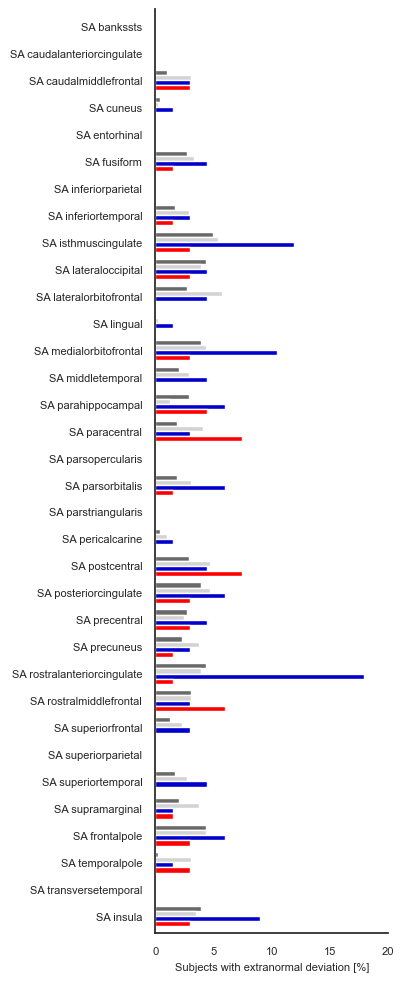

In [20]:
# adjust yticklabels
if brain_measure == 'CT':
    brain_measure_name = 'CTh'
elif brain_measure == 'SA':
    brain_measure_name = 'SA'

# calculate the percentage of subjects with extranormal deviation per ROI
print('Showing extranormal deviations for dataset:', dataset)
rois_cortical_cent = ['centile_' + roi for roi in rois_cortical]
infra_supra_all = calc_infra_supra_percentage(rois_cortical_cent, ft_scores_df, pt_scores_df)



# plot Fig 1d
fsize=8
plt.close('all')

ax = infra_supra_all.plot(x='rois', y=['infranormal_ft', 'supranormal_ft', 'infranormal_pt', 'supranormal_pt'], 
                            kind="barh", rot=0, figsize=(3,12),fontsize=fsize,
                            color=['dimgray','lightgray', 'mediumblue', 'red'],
                            legend=False, width=0.75)
# ax.legend(['Infranormal FT', 'Supranormal FT', 'Infranormal PT', 'Supranormal PT'], fontsize=fsize+1)

ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Subjects with extranormal deviation [%]', fontsize=fsize)
ax.set_ylabel('')
rois_cortical_names = [brain_measure_name + ' ' + roi.split('_')[1] for roi in rois_cortical]
ax.set_yticklabels(rois_cortical_names)

# set the x-axis limit
xlim = np.round(infra_supra_all[['infranormal_ft','supranormal_ft','infranormal_pt','supranormal_pt']].max().max()*1.1)
plt.xlim(0, xlim)

sns.despine()

plt.savefig(join(out_dir_analysis, f'{dataset}_{brain_measure}_individual_percentage_outside_norm.svg'), 
            bbox_inches="tight", dpi=300, format='svg')
plt.show()


In [21]:
# global measures
if brain_measure == 'CT':
    rois_global_cent = ['centile_' + ctv for ctv in rois_global]
    infra_supra_global = calc_infra_supra_percentage(rois_global_cent, ft_scores_df, pt_scores_df)
    
    fsize=8
    plt.close('all')

    ax = infra_supra_global.plot(x='rois', y=['infranormal_ft','supranormal_ft','infranormal_pt','supranormal_pt'], 
                                kind="barh", rot=0,figsize=(3,12/34*4),fontsize=fsize,
                                color=['dimgray','lightgray', 'mediumblue', 'red'],
                                legend=False)

    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Subjects with extranormal deviation [%]',fontsize=fsize)
    ax.set_ylabel('')
    rois_cortical_names = [roi.split('_')[1] for roi in rois_global_cent]
    ax.set_yticklabels(rois_cortical_names)

    # set the x-axis limit
    xlim = np.round(infra_supra_global[['infranormal_ft','supranormal_ft','infranormal_pt','supranormal_pt']].max().max()*1.1)
    plt.xlim(0, xlim)

    sns.despine()

    plt.savefig(join(out_dir_analysis, f'{dataset}_individual_percentage_outside_norm_global.svg'), 
                bbox_inches="tight", dpi=300, format='svg')
    plt.show()

# 4. Compare spatial similarity of IBAPs among preterm individuals 


In [22]:
out_dir = join(out_dir_main, f'IBAP_similarity_{brain_measure}')
os.makedirs(out_dir, exist_ok=True)

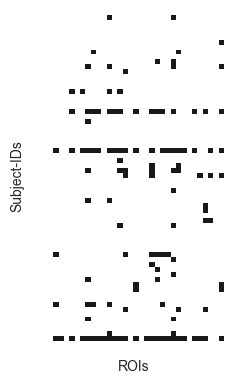

In [23]:
# binarize extranormal deviations of preterm subjects (Fig. 1e)
plt.close('all')
cent_df_pt = cent_df[cent_df['dx']=='preterm']
dev_scores_stripped_pt = cent_df_pt.filter(regex=f'centile_{brain_measure}')
dev_scores_stripped_pt_bin = binarize_extranormal(dev_scores_stripped_pt)

# plot binarized values per subject
outname = join(out_dir, f'bin_{brain_measure}_deviations_pt.svg')
plot_binarized_extranormal(dev_scores_stripped_pt_bin, title='', outname=outname)

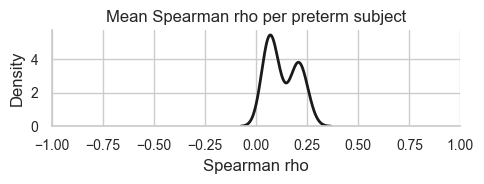

In [24]:
# subject x subject correlation matrix (Fig. 1f+g)
corr_matrix_pt_subjects_01 = dev_scores_stripped_pt_bin.T.corr(method='spearman')

# plot simplified version for all others
outname = join(out_dir, f'corrmatrix_bin_{brain_measure}_deviations.svg')
title = 'Mean Spearman rho per preterm subject'
plot_mean_rho(corr_matrix_pt_subjects_01, title, outname)

## Supplementary analysis: IBAP similarity without binarization

In [25]:
out_dir = join(out_dir_main, f'IBAP_similarity_{brain_measure}', 'supplement')
os.makedirs(out_dir, exist_ok=True)

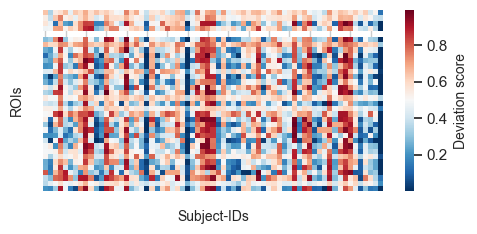

In [26]:
plt.close('all')
cent_df_pt = cent_df[cent_df['dx']=='preterm']
dev_scores_stripped_pt = cent_df_pt.filter(regex=f'centile_{brain_measure}')

# plot binarized values per subject
outname = join(out_dir, f'{brain_measure}_deviations_pt.svg')
plot_binarized_extranormal(dev_scores_stripped_pt, title='', outname=outname, bin=False)

/Users/melissa/Dokumente/PhD/01B_preterm_normative/scripts/preterm-brain-heterogeneity/code/spatial_heterogeneity.py:304: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(row_means, ax=ax_kde, vertical=True, fill=False, color='k')


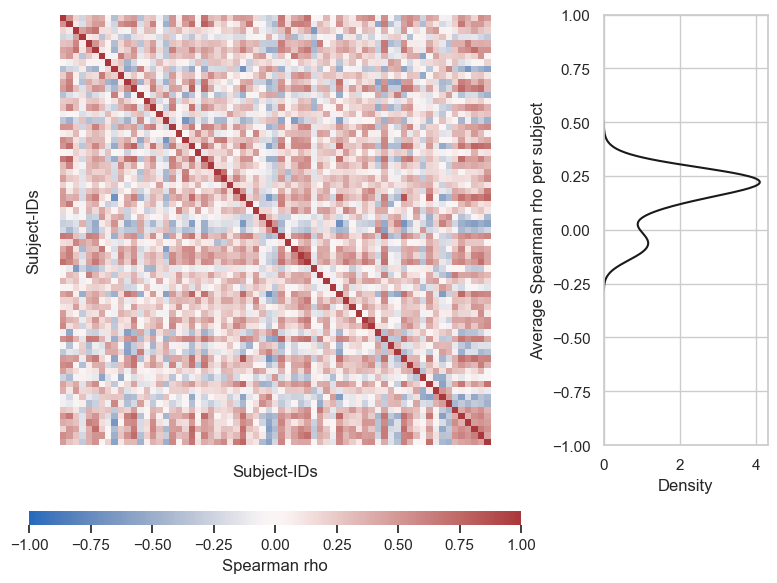

In [27]:
# subject x subject correlation matrix (Fig. 1f+g)
corr_matrix_pt_subjects = dev_scores_stripped_pt.T.corr(method='spearman')


outname = join(out_dir, f'corrmatrix_{brain_measure}_deviations.svg')
plot_correlation_matrix_kde(corr_matrix_pt_subjects, outname)



## Supplementary analysis: average correlation of IBAPs among preterm individuals
Binarized IBAPs are used to investigate whether there are patterns of extranormal deviations in the preterm group.


/Users/melissa/Dokumente/PhD/01B_preterm_normative/scripts/preterm-brain-heterogeneity/code/spatial_heterogeneity.py:304: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(row_means, ax=ax_kde, vertical=True, fill=False, color='k')


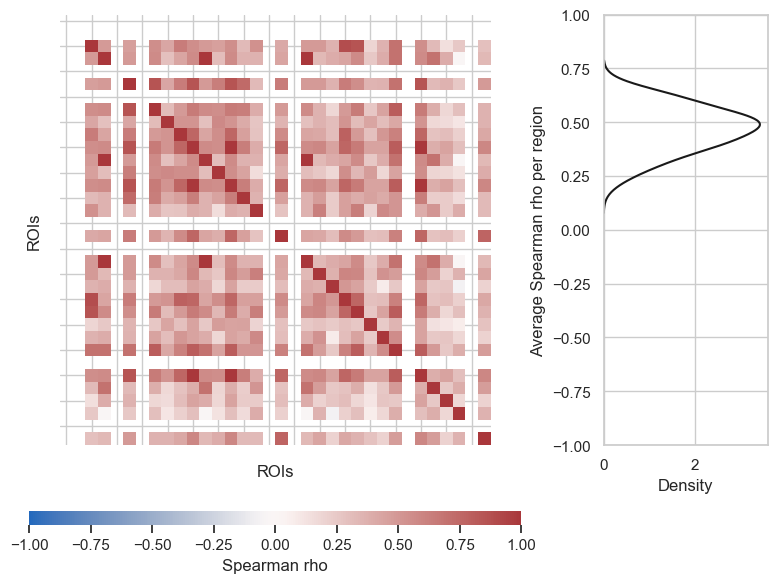

In [28]:
# region x region correlation matrix
corr_matrix_pt_subjects_rois = dev_scores_stripped_pt_bin.corr(method='spearman')

outname = join(out_dir, f'corrmatrix_{brain_measure}_deviations_regional_similarity.svg')
plot_correlation_matrix_kde(corr_matrix_pt_subjects_rois, outname, across='regions')

# 5. Correlation with cognitive measures

In [29]:
# plot settings
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rc_file('code/matplotlibrc')

from statsmodels.formula.api import ols
from scipy.stats import spearmanr

# import custom functions
import sys
sys.path.append('code')
from plotting import correlation_plot, plot_pc_loadings
from utils import read_process_output, get_roi_names
from stats import conduct_pca

color_pt = 'darkorange'


centile_dir = join(outputs_dir, 'spatial_heterogeneity')
pca_dir = join('outputs', 'developmental_plasticity_IQ', dataset)
out_dir = join(outputs_dir, 'cognition', dataset)
os.makedirs(out_dir, exist_ok=True)
#print(centile_dir)

In [30]:
# definition of variable names
dataset_vars = {
    "dHCP": {
        "cognition_var": "bsid_cog_composite",
        "cognition_label": "Bayley-III cognitive score [a.u.]",
    },
    "BLS-26": {
        "cognition_var": "IQ",
        "cognition_label": "Full-scale IQ [a.u.]",
    }
}

meta = dataset_vars[dataset]
cognition_var = meta["cognition_var"]
cognition_label = meta["cognition_label"]

In [31]:
# load PCA results
pca_ct = pd.read_csv(join(pca_dir, 'PCA_scores_CT.csv'))
pca_sa = pd.read_csv(join(pca_dir, 'PCA_scores_SA.csv'))

# exclude subjects with brain injury
pca_ct = pca_ct[pca_ct['participant'].isin(subject_list)].reset_index(drop=True)
pca_sa = pca_sa[pca_sa['participant'].isin(subject_list)].reset_index(drop=True)

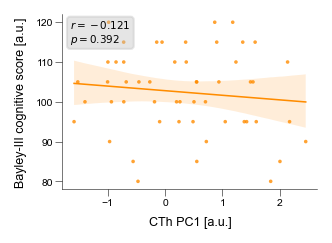

In [32]:
# PC1 of CTh
x = 'PC1_CT'
y = cognition_var
outname = join(out_dir, f'{dataset}_CT_preterm_correlation_{x}_{y}.svg')

# filter for preterms
ct_pt = pca_ct[pca_ct['dx'] == 'preterm']

correlation_plot(x, y, data=ct_pt, color=color_pt, 
                ylabel=cognition_label, xlabel='CTh PC1 [a.u.]', outname=outname)

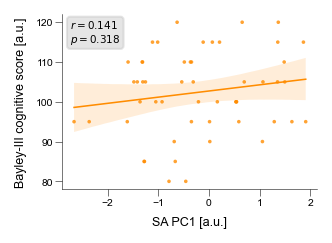

In [33]:
# PC1 of SA
x = 'PC1_SA'
y = cognition_var
outname = join(out_dir, f'{dataset}_SA_preterm_correlation_{x}_{y}.svg')

# filter for preterms
sa_pt = pca_sa[pca_sa['dx'] == 'preterm']

correlation_plot(x, y, data=sa_pt, color=color_pt, 
                ylabel=cognition_label, xlabel='SA PC1 [a.u.]', outname=outname)

In [34]:
# FDR correction of p-values
from statsmodels.stats.multitest import fdrcorrection
fdrcorrection([0.392, 0.318, 0.111, 0.016], alpha=0.05, method='indep', is_sorted=False)[1]

array([0.392, 0.392, 0.222, 0.064])